Use case example.  
In this notebook:
1. Stream hrdem-mosaic-1m collection for an area of interest
2. Use `pyflwdir` library to calculate the flow direction from the DEMs.

### **About pyflwdir Library**


`pyflwdir` is a Python library designed for flow direction analysis. It allows to compute the water flow directions based on a Digital Elevation Model (DEM). This library is useful for hydrological modeling and environmental studies. In this case, `pyflwdir` will be use to determine how water would flow across the terrain based on the elevation data provided by the High Resolution Digital Elevation Model (HRDEM) of Canada.

See : https://deltares.github.io/pyflwdir/latest/

In [1]:
import pyflwdir
import pystac_client
import stackstac
import numpy as np
import matplotlib.pyplot as plt

In [51]:
catalog = pystac_client.Client.open('https://datacube.services.geo.ca/stac/api/')  
bbox = [-116.025, 58.320, -115.90, 58.5150]
stac_items = catalog.search(collections = ['hrdem-mosaic-1m'], 
                                bbox = bbox, 
                               )

In [20]:
def reorder_transform(gdal_transform):
    """
    Reorders the GDAL GeoTransform (6-element tuple) into the 9-element format
    that is compatible with proj:transform.
    """
    return [gdal_transform[1], gdal_transform[2], gdal_transform[0],
            gdal_transform[4], gdal_transform[5], gdal_transform[3], 
            0, 0, 1]

# Create list 
list_items = []
# Use pagination
for page in stac_items.pages():
	for item in page:
            proj_transform = item.properties["proj:transform"]
            item.properties["proj:transform"] = reorder_transform(proj_transform)
            list_items.append(item)

print(len(list_items))

1


In [52]:
dtm_xarray = stackstac.stack(list_items[0], 
                          assets = ["dtm"], 
                          resolution = 1.0,
                          bounds_latlon = bbox, 
                          chunksize = (512, 512),
                          epsg = 3979)


In [53]:
dtm = dtm_xarray[0, :, :].data
print(type(dtm))
dtm

<class 'dask.array.core.Array'>


dask.array<getitem, shape=(1, 22325, 13583), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>

The `pyflwdir` library works with `NumPy` arrays, but this is a Dask array. 

Dask provides a function called **map_overlap**, that uses NumPy arrays. It allows you to define another function to be applied to all the chunks of data in parallel. Dask will pass each chunk of data as a NumPy array to the function. 

Dask handles the parallel processing of the chunks, and once all the chunks are processed, it will combine them into a full array. It allows you to take advantage of both Dask’s parallel processing and pyflwdir's ability to work with NumPy arrays.

See : https://docs.dask.org/en/latest/generated/dask.array.map_overlap.html

In [6]:
def flow_dir(block_data,latlon):
    
    if not np.all(np.isnan(block_data[0, :, :])):
        
        # Create flow direction from DEM data
        flw = pyflwdir.from_dem(
            data = block_data[0, :, :],
            nodata = np.nan,
            latlon=latlon
        )
        # Convert the flow data to an array
        flow_array = flw.to_array()
        flow_array = flow_array.astype(float)
        flow_array[np.isnan(block_data[0, :, :])] = np.nan

        return flow_array
    else:
        
        return np.full((block_data.shape[1], block_data.shape[2]), np.nan)

In [54]:
flow_direction = dtm.map_overlap(flow_dir, 
                                latlon=dtm_xarray.crs, 
                                depth = {"x": 1000, "y": 1000}, # The number of elements that each block should share with its neighbors
                                chunks = (1000, 1000), drop_axis=0, dtype =np.float32)

In [26]:
print(flow_direction)

dask.array<flow_dir, shape=(25000, 21000), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>


Compute the results. This may take longer since the data is being read and written into the Dask array.

In [55]:
flow_direction = flow_direction.compute()

Let's visulaize the results! 

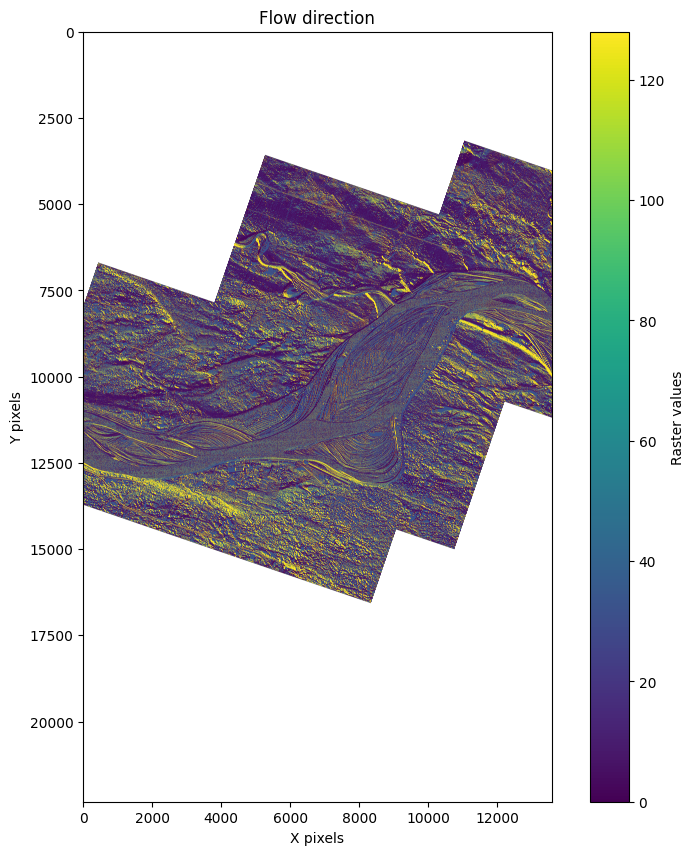

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(flow_direction, cmap='viridis') 
plt.colorbar(label='Raster values') 
plt.title('Flow direction')
plt.xlabel('X pixels')
plt.ylabel('Y pixels')
plt.show()